# Bootcamp SQL

### [Excalidraw](https://app.excalidraw.com/l/8pvW6zbNUnD/3ktnOgfFeRK)
### [github](https://github.com/lvgalvao/data-engineering-roadmap/tree/main/Bootcamp%20-%20SQL%20e%20Analytics)


## Aula 1

Por que Postgres?
- opensource - de graça
- presente em várias empresas
- um dos principais bancos na logica cliente-servidor
- suporta tipos complexos como json

consultar a documentação (link na aula 1 readme)

Comandos principais
- SELECT
  - SELECT colunas ou * FROM tabela
  - SELECT distinct coluna FROM tabela
  - SELECT count(distinct coluna) FROM tabela
- WHERE
  - SELECT * FROM tabela WHERE coluna = 'valor' AND coluna2 = 'valor2'
  - SELECT * FROM tabela WHERE coluna <> 'valor'
  - SELECT * FROM tabela WHERE coluna = 'valor' AND (coluna2 = 'valor2' OR coluna2 = 'valor3')
- ORDER BY
  - SELECT * FROM tabela ORDER BY coluna1 ASC, coluna2 DESC
  - SELECT * FROM tabela ORDER BY coluna1, coluna2
- LIKE e IN (é pesado, poderia concatenar varias colunas em um e dar like nessa coluna quando queremos multiplos likes. O ILIKE resolve o case senstivie to LIKE)
  - SELECT * FROM tabela WHERE coluna LIKE 'a%'
  - SELECT * FROM tabela WHERE coluna NOT LIKE 'a%'
  - SELECT * FROM customers WHERE coluna IN ('valor1', 'valor2', 'valor3')
  - SELECT * FROM customers WHERE coluna LIKE '%or%'
  - SELECT * FROM customers WHERE coluna LIKE '%_r%' (r na segunda posição, '_' significa qualquer caractere)
  - SELECT * FROM customers WHERE coluna LIKE 'a%o' (começa com 'a' e termina com 'o')
  - SELECT * FROM customers WHERE coluna LIKE 'a__%' (começa com 'a' e pelo menos 3 caracteres)
- MAIS AVANÇADOS (gostinho de subquery)
  - SELECT * FROM customers WHERE coluna IN (SELECT DISTINCT coluna from tabela)
  - SELECT * FROM customers WHERE coluna BETWEEN 10 AND 20 (not NOT BETWEEN)
  - SELECT TO_CHAR(data, 'DD-MM-YYY') FROM tabela WHERE order_date between '1996-04-07' and '1996-09-07' (converte data em outro formato)
- Agregadores
  - MIN, MAX, AVG, COUNT, SUM - normalmente usadas com GROUP BY
  - LIMIT # (limita a qtde de resultados)

## Aula 2

Podemos ir no PGAdmin e dentro do banco na parte de Login/Group Roles podemos definir permissões de acesso

- SELECT é usado para consultar dados
- INSERT, UPDATE E DELETE normalmente sao mais usados por engenheiros de dados e principalmente sistemas com esse tipo de acesso (por exemplo CRUD)
- CREATE, ALTER, DROP sao mais usados por DBA e modeladores do banco
- GRANT, REVOKE tem a ver com acesso, usado por admin do banco - tira, dá ou deleta conta
- BEGIN, COMMIT, ROLLBACK tem a ver com transações. porém transações sempre sao um conjunto de comandos. Porém para garantir a atomicidade, colocamos os statements entre um BEGIN e um COMMIT para garantir que tudo que está entre eles rode. Caso algo dê errado no entre BEGIN e COMMIT, a transação nao acontece. Se der um erro eu posso usar o ROLLBACK para voltar, como se fosse um try/except do python

Sempre trazer as colunas que precisamos, evitar usar o SELECT * pq pressiona a performance


# Aula 3

importante a sequencia de comandos em SQL:
1. select
2. from
3. join
4. where
5. group by
6. having
7. order by
8. limit

## Joins

- Inner (padrão)
- left 
- right
- full
- cross (menos utilizada)

Se estamos usando funções agregadoras no select, o que nao está sendo agregado precisa estar no group by

# Aula 4 - Window functions

Como se criasse nova coluna, similar a usar um dataframe no pandas

Sintaxe:
window_function_name(arg1, arg2, ...) OVER (
  [PARTITION BY partition_expression, ...]
  [ORDER BY sort_expression [ASC | DESC], ...]
)

windows function permite atingir o mesmo resultado com statements diferentes. Exemplo do Northwind:

```sql
SELECT order_id,
       COUNT(order_id) AS unique_product,
       SUM(quantity) AS total_quantity,
       SUM(unit_price * quantity) AS total_price
FROM order_details
GROUP BY order_id
ORDER BY order_id;

-- é equivalente a 

SELECT DISTINCT order_id,
   COUNT(order_id) OVER (PARTITION BY order_id) AS unique_product,
   SUM(quantity) OVER (PARTITION BY order_id) AS total_quantity,
   SUM(unit_price * quantity) OVER (PARTITION BY order_id) AS total_price
FROM order_details
ORDER BY order_id;
```

Windows function basicamente substitui o group by porém é feito ao nível de linha e o OVER + PARTITION BY deve ser incorporado a todas as colunas selecionadas. 

POdemos inclusive fazer o partition by para colunas diferentes gerando agrupamentos diferentes por linha

É possível ter mais de uma coluna em um partition by, o que pode ser útil para algumas análises

A boa prática é já trazer o dado do SQL do jeito que vc precisa, vc pode até trazer o dado bruto e tratar em outro local como um pandas, porém estará consumindo mais memória. Ex: 
- se vc joga um select * from e manda pro powerbi vai ficar lento e vai ter q ter cálculo no pbi, que não é o ideal.
- O mesmo vale para regra de negócio colocada no front end que não é o ideal, como calcular um desconto no frontend ao invés de ter isso já calculado no banco

Em termos de performance podemos usar EXPLAIN ou EXPLAIN ANALYZE antes da query para ver a performance

RANK, DENSE e ROWNUMBER servem para fazer ordenação com base em alguma coisa:
- ROWNUMBER nao tem repetido, ele dá um jeito de desempatar, usa uma coluna ID implícita para ordenar, é não-determinístico em caso de empate
- RANK tem repetido, nao desempata e ordena normalmente, entao se tem 2 em 1o, o próximo será 3o         
- DENSE tem repetido, nao desempata e ordena pulando, entao se tem 2 em 1o, o próximo será 2o         

PERCENT_RANK() e CUME_DIST() sao menos utilizados mas podem ser úteis quando queremos ver % dentro de grupos

NTILE() é usada para dividir o conjunto de resultados em um número especificado de partes aproximadamente iguais ou "faixas" e atribuir um número de grupo ou "bucket" a cada linha com base em sua posição dentro do conjunto de resultados ordenado.

LAG() e LEAD() serve para comparar e ver evoluções / variações

# Exercícios Aula 4 (chat-gpt/Northwind)

Group 1: RANK, DENSE_RANK, ROW_NUMBER
Exercises:
1. Rank orders by their total value (descending) for each customer. Include ties.

```sql
SELECT
	c.company_name,
	o.order_id,
	SUM(od.unit_price * od.quantity) AS order_total,
	RANK() OVER(PARTITION BY c.company_name ORDER BY SUM(od.unit_price * od.quantity) DESC) AS order_rank
FROM
	customers c
JOIN
	orders o on c.customer_id = o.customer_id
JOIN
	order_details od on o.order_id = od.order_id
GROUP BY
	c.company_name, o.order_id, od.unit_price, od.quantity
```


2. Rank products (DENSE_RANK) based on the number of orders placed, grouped by category.

```sql
SELECT
	p.product_name,
	c.category_name as category,
	COUNT(od.order_id) AS order_qty,
	DENSE_RANK() OVER(PARTITION BY c.category_name ORDER BY COUNT(od.order_id) DESC) AS order_dense
FROM
	products p
JOIN
	categories c on p.category_id = c.category_id
JOIN
	order_details od on p.product_id = od.product_id
GROUP BY
	p.product_name, c.category_name
```

3. Assign a row number (ROW_NUMBER) to each employee within their respective city, ordered by their hire date.
4. Rank employees by their sales amount. Use RANK to ensure ties are ranked the same and leave gaps in ranks.
5. Assign ROW_NUMBER to products within each supplier, ordered by price.


Group 2: PERCENT_RANK, CUME_DIST
Exercises:
1. Calculate the PERCENT_RANK of each order based on its total value, grouped by customer.
```sql
SELECT
	c.company_name,
	o.order_id,
	SUM(od.unit_price * od.quantity) AS total_value,
	ROUND(CAST(PERCENT_RANK() OVER (PARTITION BY o.order_id ORDER BY (od.unit_price * od.quantity) DESC) AS numeric),2) AS order_rank
FROM
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
JOIN 
	order_details od ON od.order_id = o.order_id
GROUP BY c.company_name, o.order_id, od.unit_price, od.quantity
```
2. Compute the PERCENT_RANK of employees based on their hire date (earliest hire date = 0, latest = 1).
3. Calculate the CUME_DIST of orders based on their total value across all orders (not grouped).
4. Determine the CUME_DIST of products based on their price, grouped by category.
```sql
SELECT
	c.category_name,
	p.product_name,
	p.unit_price,	
	ROUND(CAST(CUME_DIST() OVER (partition by c.category_name ORDER BY p.unit_price DESC) AS numeric),4) as cum_percent
FROM
	products p
JOIN
	categories c on c.category_id = p.category_id
	
GROUP BY 
	p.product_name, p.unit_price
```
5. For each employee, compute the PERCENT_RANK of their total sales.

Group 3: NTILE
Exercises:
1. Divide all orders into 4 equal-sized groups (quartiles) based on their total value.
```sql
SELECT
	od.order_id,
	ROUND(CAST(SUM(od.unit_price * od.quantity) AS NUMERIC),0) AS total_value,
	NTILE(4) OVER (ORDER BY SUM(od.unit_price * od.quantity) DESC) AS ntile_rank
FROM
	order_details od
GROUP BY 
	od.order_id
```
2. Divide employees into 5 NTILE groups based on their hire date, with the earliest hire date in NTILE 1.
3. Categorize products into 3 NTILE groups within each category, based on their unit price.
4. Partition orders by year and assign each order to 4 NTILE groups based on their total value within that year.
```sql
SELECT
	od.order_id,
	EXTRACT(YEAR FROM o.order_date) as order_year,
	ROUND(CAST(SUM(od.unit_price * od.quantity) AS NUMERIC),0) AS total_value,
	NTILE(4) OVER (PARTITION BY EXTRACT(YEAR FROM o.order_date) ORDER BY SUM(od.unit_price * od.quantity) DESC) AS ntile_rank
FROM
	order_details od
JOIN
	orders o on o.order_id = od.order_id
GROUP BY 
	od.order_id, o.order_date
```
5. Divide customers into 10 NTILE groups based on the total number of orders placed by each.

Group 4: LAG, LEAD
Exercises:
1. For each order, use LAG to calculate the time difference (in days) between the current order and the previous order for the same customer.
```sql
SELECT
	o.order_id,
	c.company_name,
	o.order_date,
	o.order_date - LAG(o.order_date) OVER (PARTITION BY o.customer_id ORDER BY o.order_date) AS day_diff
FROM
	orders o
JOIN
	customers c on c.customer_id = o.customer_id
```
2. For each product, use LEAD to display the unit price of the next product within the same category.
3. For each employee, compute their sales amount and show the sales amount of the previous employee using LAG.
4. For each order, display the next order's total value for the same customer using LEAD.
```sql
SELECT 
    orders.customer_id,
    orders.order_id,
	orders.order_date,
    ROUND(CAST(SUM(od.unit_price * od.quantity) AS numeric),2) AS total_value,
    ROUND(CAST(LEAD(SUM(od.unit_price * od.quantity)) OVER (PARTITION BY orders.customer_id ORDER BY orders.order_id ASC) AS numeric),2) AS NextOrderValue
FROM
	orders
JOIN
	order_details od ON od.order_id = orders.order_id
GROUP BY
	orders.customer_id, orders.order_id
```
5. For each product, calculate the difference between its unit price and the unit price of the next product in the same category using LEAD.

# Aula 5 - Projeto SQL

Dicas para teste técnico:
- Entregar testes técnicos como um repositório git bem organizado
- Colocar as queries no readme do repositório e também uma por arquivo .sql em uma pastinha no repositório
- Colocar contexto (explicação sobre o que é o banco)
- Configuração inicial / como usar e instalar o repositório
- Colocar tudo em um docker container e setar o docker compose

# Aula 5 desafio

Precisamos pensar na performance da query, pois duas queries que geram o mesmo resultado podem ter performances diferentes. ex:

Consulta 1 (menos performática pois o join é com a tabela completa)
```sql
SELECT 
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1.0 - od.discount)) AS numeric),0) AS total_net_sales
FROM
	order_details od
JOIN
	orders o ON o.order_id = od.order_id
WHERE
	EXTRACT(YEAR FROM o.order_date) = '1997'
```

Consulta 2 (mais performática, pq gera uma consulta só com ano de 1997 antes de fazer o join)

```sql
SELECT SUM((order_details.unit_price) * order_details.quantity * (1.0 - order_details.discount)) AS total_revenues_1997
FROM order_details
INNER JOIN (
    SELECT order_id 
    FROM orders 
    WHERE EXTRACT(YEAR FROM order_date) = '1997'
) AS ord 
ON ord.order_id = order_details.order_id;
```

Nao exist WHERE e HAVING de CTE, precisa rodar uma SELECT com WITH e depois fazer um SELECT com WHERE


In [ ]:
-- Qual foi o total de receitas no ano de 1997?

CREATE VIEW total_revenue_1997 AS
SELECT 
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1.0 - od.discount)) AS numeric),0) AS total_net_sales
FROM
	order_details od
JOIN
	orders o ON o.order_id = od.order_id
WHERE
	EXTRACT(YEAR FROM o.order_date) = '1997'


In [ ]:
-- Faça uma análise de crescimento mensal e o cálculo de YTD

CREATE VIEW month_ytd_growth AS 
WITH ReceitasMensais AS (
	SELECT
		EXTRACT(YEAR FROM o.order_date) as order_year,
		EXTRACT(MONTH FROM o.order_date) as order_month,
		ROUND(CAST(SUM((od.unit_price * od.quantity) * (1.0 - od.discount)) AS numeric),0) AS month_revenue
	FROM
		orders o
	JOIN
		order_details od on od.order_id = o.order_id
	GROUP BY
		EXTRACT(YEAR FROM o.order_date),
		EXTRACT(MONTH FROM o.order_date)
	), 
	ReceitasAcumuladas AS (
		SELECT 
			order_year,
		 	order_month,
			month_revenue,
			SUM(month_revenue) OVER (PARTITION BY order_year ORDER BY order_month) as receita_ytd
		FROM
			ReceitasMensais
	)
	SELECT
		order_year,
		order_month,
		month_revenue,
		month_revenue - LAG(month_revenue) OVER (PARTITION BY order_year ORDER BY order_month) AS month_diff,
		receita_ytd,
		ROUND(
			CAST(
				(month_revenue - LAG(month_revenue) 
				OVER (PARTITION BY order_year ORDER BY order_month)) / 
				LAG(month_revenue) 
				OVER (PARTITION BY order_year ORDER BY order_month) * 100 AS numeric),2) AS pct_month_change
	FROM 
		ReceitasAcumuladas
	ORDER BY
		order_year,
		order_month
	

In [ ]:
-- Segmentação de clientes. Qual é o valor total que cada cliente já pagou até agora?

CREATE VIEW net_sales_per_customer AS
SELECT
	c.company_name,
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) as net_sales
FROM
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
JOIN
	order_details od ON od.order_id = o.order_id
GROUP BY
	c.company_name
ORDER BY
	SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC

In [ ]:
-- Separe os clientes em 5 grupos de acordo com o valor pago por cliente

CREATE VIEW customer_groups AS
SELECT
	c.company_name,
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) as net_sales,
	NTILE(5) OVER (ORDER BY SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC) as ntile_group
FROM
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
JOIN
	order_details od ON od.order_id = o.order_id
GROUP BY
	c.company_name
ORDER BY
	SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC

In [ ]:
-- Agora somente os clientes que estão nos grupos 3, 4 e 5 para que seja feita uma análise de Marketing especial com eles


CREATE VIEW customer_groups_123 AS
WITH marketing_customers AS(
	SELECT
		c.company_name,
		ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) as net_sales,
		NTILE(5) OVER (ORDER BY SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC) as ntile_group
	FROM
		customers c
	JOIN
		orders o ON o.customer_id = c.customer_id
	JOIN
		order_details od ON od.order_id = o.order_id
	GROUP BY
		c.company_name
	ORDER BY
		SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC
)
SELECT * 
FROM marketing_customers
WHERE ntile_group <= 3

In [ ]:
-- Top 10 Produtos Mais VendidosIdentificar os 10 produtos mais vendidos.. 

CREATE VIEW most_revenue_products AS
SELECT
	p.product_name,
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) as net_sales
FROM
	products p
JOIN
	order_details od ON od.product_id = p.product_id
GROUP BY
	p.product_name
ORDER BY
	SUM((od.unit_price * od.quantity) * (1 - od.discount)) DESC
LIMIT 10

In [ ]:
-- Clientes do Reino Unido que Pagaram Mais de 1000 Dólares. Quais clientes do Reino Unido pagaram mais de 1000 dólares?
CREATE VIEW uk_customers_above1000 AS
SELECT
	c.company_name,
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) AS net_sales
FROM
	customers c
JOIN
	orders o ON o.customer_id = c.customer_id
JOIN
	order_details od on od.order_id = o.order_id
WHERE 
	c.country = 'UK'
GROUP BY
	c.company_name
HAVING
	ROUND(CAST(SUM((od.unit_price * od.quantity) * (1 - od.discount)) AS numeric),0) > 1000

SyntaxError: invalid syntax (4052326442.py, line 2)

# Aula 6

## CTE, Subquery, View e View materializada

Here’s a detailed comparison of **SQL CTEs (Common Table Expressions)**, **Subqueries**, **Views**, **Temporary Tables**, and **Materialized Views** based on their similarities, differences, advantages, disadvantages, and real-life use cases.

---

## **1. Overview**

| **Feature**         | **Description**                                                                                           |
|---------------------|-----------------------------------------------------------------------------------------------------------|
| **CTEs**            | Temporary, named result sets used within a single query. Declared using `WITH`.                           |
| **Subqueries**      | Queries nested inside another query (can appear in `SELECT`, `FROM`, or `WHERE` clauses).                 |
| **Views**           | Named, reusable SQL queries stored in the database. Executes every time it is referenced.                 |
| **Temporary Tables**| Tables that exist only for the duration of a session or transaction.                                      |
| **Materialized Views**| Precomputed, stored result sets that can be refreshed on demand or periodically.                         |

---

## **2. Similarities**

1. **Reusable Logic**:
   - All allow breaking complex queries into simpler components.

2. **Encapsulation**:
   - Each provides a way to encapsulate SQL logic, improving readability and maintainability.

3. **Integration**:
   - Can be used in conjunction with joins, aggregations, and filtering in complex queries.

---

## **3. Differences**

| **Feature**          | **Scope**                   | **Execution**                                    | **Persistence**                      | **Performance**                          |
|----------------------|-----------------------------|------------------------------------------------|--------------------------------------|------------------------------------------|
| **CTEs**             | Query scope (temporary).    | Re-evaluated for each query execution.          | Not stored; temporary to the query.  | Good for breaking down queries but slower for reuse. |
| **Subqueries**       | Query scope (temporary).    | Re-evaluated for each query execution.          | Not stored; inline within query.     | Inline execution; less readable for complex queries. |
| **Views**            | Database scope (persistent).| Re-evaluated each time it is queried.           | Stored in the database.              | Depends on the query; no precomputation.             |
| **Temporary Tables** | Session or transaction.     | Evaluated once when created.                    | Exists for the session/transaction.  | Optimized for reuse during the session.              |
| **Materialized Views**| Database scope (persistent).| Query results precomputed and stored.           | Stored in the database.              | Faster for repeated use; requires maintenance to refresh. |

---

## **4. Advantages and Disadvantages**

### **CTEs**
- **Advantages**:
  - Simplifies query readability by breaking queries into smaller parts.
  - Supports recursion (e.g., hierarchical data).
  - Temporary; does not clutter database.
- **Disadvantages**:
  - Recomputed every time the query runs, potentially reducing performance for large datasets or frequent reuse.

---

### **Subqueries**
- **Advantages**:
  - Inline, self-contained, and requires no external definitions.
  - Works well for one-off operations.
- **Disadvantages**:
  - Hard to read and debug when deeply nested.
  - Cannot reuse logic; duplication is required for similar subqueries.

---

### **Views**
- **Advantages**:
  - Centralized logic: Simplifies reuse across applications and queries.
  - Improves code maintainability.
  - Abstracts database complexity for end users.
- **Disadvantages**:
  - Performance depends on the underlying query and database engine.
  - Cannot store precomputed results; always executes the underlying query.

---

### **Temporary Tables**
- **Advantages**:
  - Ideal for intermediate calculations and large transformations.
  - Can be indexed for better performance during the session.
- **Disadvantages**:
  - Requires manual cleanup if used improperly.
  - Adds overhead due to creation and deletion during the session.

---

### **Materialized Views**
- **Advantages**:
  - Significant performance boost for repeated queries.
  - Precomputed results reduce computation overhead.
  - Can be refreshed periodically or on-demand.
- **Disadvantages**:
  - Requires storage space for precomputed results.
  - Must be refreshed to reflect updated underlying data.

---

## **5. Real-Life Use Cases**

| **Feature**          | **Use Case**                                                                                                                                          |
|----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **CTEs**             | - Simplifying a complex query for sales trend analysis.                                                                                             |
|                      | - Implementing recursive queries to manage hierarchical data like organizational structures.                                                         |
| **Subqueries**       | - Filtering rows based on aggregate conditions (e.g., products with sales above average).                                                           |
|                      | - Dynamically calculating derived values, such as ranks, inline.                                                                                    |
| **Views**            | - Centralized reusable queries for analytics dashboards (e.g., monthly revenue report).                                                             |
|                      | - Abstracting joins and complex relationships for end-user query interfaces.                                                                         |
| **Temporary Tables** | - Intermediate calculations during ETL processes.                                                                                                   |
|                      | - Complex report generation that requires multiple transformations.                                                                                 |
| **Materialized Views**| - Frequently accessed summary reports (e.g., total revenue by region).                                                                              |
|                      | - Precomputing and storing aggregates for large datasets like time-series data to speed up queries.                                                 |

---

## **6. When to Use Each**

| **Feature**           | **When to Use**                                                                                               |
|-----------------------|-------------------------------------------------------------------------------------------------------------|
| **CTEs**              | Use when you need to improve query readability or work with temporary, reusable logic within a single query. |
| **Subqueries**        | Use for quick, inline operations that don't need reuse or external storage.                                  |
| **Views**             | Use when you need reusable logic across multiple queries and want to abstract database complexity.           |
| **Temporary Tables**  | Use for intermediate steps in a process that requires multiple queries within a session or transaction.      |
| **Materialized Views**| Use for performance-critical queries that require precomputed and reusable results.                          |

---

### Example Scenarios with SQL Code

#### **CTE Example**
Find employees with salaries above the department average:
```sql
WITH DeptAvg AS (
    SELECT DepartmentID, AVG(Salary) AS AvgSalary
    FROM Employees
    GROUP BY DepartmentID
)
SELECT e.EmployeeID, e.Salary
FROM Employees e
JOIN DeptAvg d ON e.DepartmentID = d.DepartmentID
WHERE e.Salary > d.AvgSalary;
```

---

#### **Subquery Example**
Find products with prices above the average price:
```sql
SELECT ProductID, ProductName
FROM Products
WHERE UnitPrice > (SELECT AVG(UnitPrice) FROM Products);
```

---

#### **View Example**
Create a view for total sales by category:
```sql
CREATE VIEW TotalSalesByCategory AS
SELECT c.CategoryName, SUM(od.Quantity * od.UnitPrice) AS TotalSales
FROM Categories c
JOIN Products p ON c.CategoryID = p.CategoryID
JOIN OrderDetails od ON p.ProductID = od.ProductID
GROUP BY c.CategoryName;
```
Query the view:
```sql
SELECT * FROM TotalSalesByCategory;
```

---

#### **Temporary Table Example**
Store intermediate sales data:
```sql
CREATE TEMP TABLE SalesTemp AS
SELECT CustomerID, SUM(TotalAmount) AS TotalSpent
FROM Orders
GROUP BY CustomerID;

SELECT * FROM SalesTemp WHERE TotalSpent > 1000;
```

---

#### **Materialized View Example**
Precompute total sales by product:
```sql
CREATE MATERIALIZED VIEW TotalSalesByProduct AS
SELECT ProductID, SUM(Quantity * UnitPrice) AS TotalSales
FROM OrderDetails
GROUP BY ProductID;

-- Refresh the materialized view:
REFRESH MATERIALIZED VIEW TotalSalesByProduct;

-- Query the materialized view:
SELECT * FROM TotalSalesByProduct;
```

---

### **Summary Table**

| **Feature**            | **Best For**                          | **Reusable** | **Performance**           | **Persistent** | **Ideal For Large Datasets** |
|------------------------|---------------------------------------|--------------|---------------------------|----------------|-----------------------------|
| **CTEs**               | Readability, recursion               | No           | Slower (re-evaluates)     | No             | No                          |
| **Subqueries**         | Inline calculations                  | No           | Slower (re-evaluates)     | No             | No                          |
| **Views**              | Reusable queries                     | Yes          | Moderate                  | Yes            | No                          |
| **Temporary Tables**   | Intermediate storage during sessions | No           | Moderate to fast          | No             | Yes                         |
| **Materialized Views** | Precomputed reusable results         | Yes          | Fast (precomputed)        | Yes            | Yes                         |


## Quick guide for SQL objects

[link](https://www.linkedin.com/feed/update/urn:li:activity:7190722950499577856/)

1. Sua análise é simples e direta? Se sim use query, senao avance
2. A análise necessita de  interacoes com multiplas tabelas ou dados relacionados? se sim use subquery, senao avance
3. A consulta é para uma análise única e complexa mas vc quer manter legibilidade? se sim use CTE, senao avance
4. Voce está lidando com uma analise ao longo do dia e quer  manter a estrutura organizada sem afetar o esquema principal? se sim use TempView, senao avance
5. Voce está criando relatórios ou dashboards que seráo utilizados com frequencia e precisa de acessos e permissoes diferenciadas? se sim use view, senao avance
6. voce está tentando novas consultas como estratégia de index ou precisa armazenar dados por um curto período? se sim use TempTable, senao avance
7. Voce precisa armazenar informacoes a longo prazo? Elas serao usadas pela aplicacao principal para CRUD? se sim use tabela, senao avance
8. Os dados serao usados por milhoes de usuarios (ex black friday)? Se sim use estrutura de cache do redis
9. Essa análise sera feita frequentemente e envolve qtde massiva de dados? se sim, migrar para BD OLAP


Quando lidamos com codigo / banco antigos as vezes perdemos os indices quando usamos CTE mas nao quando usamos subquery

CTE recursivo serve mais quando estamos lidando com hierarquias em contextos especificos

A view guarda o metadado que eh a query, porem nem CTE, nem subquery e nem view guardam os dados em si. A ocupacao de memoria da view eh desprezivel

view, CTE e subquery tem a mesma performance

na view podemos usar index e podemos gerenciar acesso com GRANT

temp table grava o resultado entao se for chamar ela de novo na mesma sessao ela nao vai reprocessar, vai trazer direto o resultado. Vale quando vou reutilizar a query e ela demora pra rodar. entao faz a temp table e usa varias vezes

tudo que eh temp morre quando encerra a sessao

materialized view ou snapshot 
- guarda o metadado e o resultado alocando memoria para cada snapshot, 
- tem index, 
- parece uma tabela que eu nao posso alterar. 
- Para atualizar preciso rodar o REFRESH. 
- Vai tirando snapshots de tempos em tempos para saber como estavam os dados em determinados momentos. 
- pode ser gerada somente quando temos alteracoes nos dados
- facilita para auditoria

vacuum eh a desfragmentacao de disco


# Aula 7 e 8- Stored Procedures

Stored Procedures tendem a ser preferidas por DBAs mas nao por desenvolvedores backend

O que é - como se fosse uma funçao porém nao tem retorno, o objetivo é alterar coisas já existentes no banco (tabela, valores, etc) é uma rotina armazenada no banco da dados

Analistas e sistemas podem invocar um stored procedure. Backend ou frontend podem consumir. Ao inves de colocar a regra na API podemos colocar no banco de dados. Tem q ver qual a melhor estratégia

Se for feito stored procedure, ele fica no banco, logo está sob o domínio do DBA e nao do time de desenvolvimento ou de dados

podemos gerenciar acesso no nivel da stored procedure e nao da tabela, caso conveniente

quando colocamos SERIAL em uma coluna, estamos delegando ao banco fazer o sequenciamento. 

Podemos rodar tambem um UID que anonimiza o numero, o que é uma boa prática Para usar o UUID rodar o comando abaixo:

```sql
CREATE EXTENSION IF NOT EXISTS "uuid-ossp";

CREATE TABLE IF NOT EXISTS clients (
    id UUID PRIMARY KEY DEFAULT uuid_generate_v4(),
    limite INTEGER NOT NULL,
    saldo INTEGER NOT NULL
);
```

O comando DELETE é similar ao SELECT em termos de sintaxe

O tipo de variável CHAR em sql tem um número de caracteres definido, o VARCHAR pode variar de 1 até o numero estipulado

No exemplo do banco itau precisamos de uma funcao que
1. veja o saldo e o limite docliente
2. compare, em caso de tipo 'd'se saldo + limite >= transacao
3. criar a transacao
4. atualizar o saldo 

Alem disso precisamos colocar checks na tabela de clients, entao quando da criacao da tabela, incluimos constraints

```sql
CREATE TABLE IF NOT EXISTS clients (
    id UUID PRIMARY KEY DEFAULT uuid_generate_v4(),
    limite INTEGER NOT NULL,
    saldo INTEGER NOT NULL,
    CHECK (saldo >= limite)

);
```
Sempre precisamos pensar se as nossas tabelas precisam de constaints e adicionar caso necessário

PAra criar stored procedures usamos CREATE OR REPLACE PROCEDURE nome (), daí passamos os parametros. É importante definir se sao parametros que entram (IN) ou que saem/extraem (OUT)



# Aula 9 Triggers

observam eventos de insert into, update, delete

em DB preferimos usar dados do tipo integer ou decimal(10,2), evitar ao máximo float

Trigger é uma regra de negocio associada a uma tabela. Por isso nao dá pra fazer trigger em duas tabelas ao mesmo tempo

POdemos ter cenarios do tipo:
1. Store procedure atualiza title do employee, a atualizaçao do title dispara um trigger que execute uma funcao que adiciona o title antigo e o novo em uma tabela de auditoria
2.  Criamos uma materialized view que precisa de refresh a cada atualizacao de duas outras tabelas, entao criamos 2 triggers iguais de update em cada uma das tabelas, esses triggers executam a mesma funcao que dá refresh na materialized view
3. Star Schema - temos tabelas do tipo orders, order_details e product_details, podemos criar triggers nelas que a cada alteracao (insert, update ou delete) executamos uma funçao que faz o INSERT INTO uma tabela do tipo factVendas

Converting the Microsoft **Northwind database** into a **Star Schema** involves reorganizing the relational database tables into a structure optimized for analytical queries and reporting. A Star Schema typically consists of a **central fact table** surrounded by **dimension tables**.

Here’s how to approach the transformation step by step:

---

## **Step 1: Understand the Existing Northwind Schema**
The Northwind database is a traditional OLTP (Online Transaction Processing) schema, with normalized tables such as `Orders`, `Products`, `Customers`, and `Suppliers`. Study the existing schema:
- Identify **key tables** like `Orders`, `OrderDetails`, `Products`, and `Employees`.
- Understand relationships:
  - Example: `Orders` is linked to `OrderDetails`, which is linked to `Products`.

---

## **Step 2: Define the Fact Table**
The **fact table** will hold the metrics you want to analyze, such as `sales`, `quantity`, or `profit`. In the Northwind context, the fact table will likely represent **sales transactions**.

**Fact Table: `FactSales`**
- **Measures**: Numeric values for analysis, e.g., `OrderQuantity`, `TotalSales`.
- **Foreign Keys**: References to dimension tables.
- Source tables: `OrderDetails` (for product-level order data) and `Orders` (for order metadata).

**Columns**:
| Column Name      | Description                         |
|------------------|-------------------------------------|
| `OrderID`        | Links to the `Orders` table.        |
| `ProductID`      | Links to the `Products` table.      |
| `CustomerID`     | Links to the `Customers` table.     |
| `EmployeeID`     | Links to the `Employees` table.     |
| `OrderDate`      | Date of the order.                  |
| `Quantity`       | Total quantity ordered.             |
| `UnitPrice`      | Price per unit of the product.      |
| `TotalSales`     | Calculated as `Quantity * UnitPrice`.|

---

## **Step 3: Define Dimension Tables**
Dimension tables provide context for analysis (e.g., "Who bought the product?" "When was it sold?").

### **Dimension 1: `DimCustomer`**
- **Purpose**: Store customer details.
- **Source**: `Customers` table.

**Columns**:
| Column Name      | Description               |
|------------------|---------------------------|
| `CustomerID`     | Primary key.              |
| `CustomerName`   | Name of the customer.     |
| `Region`         | Geographic region.        |
| `Country`        | Country of the customer.  |
| `City`           | City of the customer.     |

---

### **Dimension 2: `DimProduct`**
- **Purpose**: Store product details.
- **Source**: `Products` table.

**Columns**:
| Column Name      | Description               |
|------------------|---------------------------|
| `ProductID`      | Primary key.              |
| `ProductName`    | Name of the product.      |
| `Category`       | Product category.         |
| `SupplierID`     | Links to the supplier.    |
| `UnitPrice`      | Price per unit.           |

---

### **Dimension 3: `DimEmployee`**
- **Purpose**: Store employee details.
- **Source**: `Employees` table.

**Columns**:
| Column Name      | Description               |
|------------------|---------------------------|
| `EmployeeID`     | Primary key.              |
| `EmployeeName`   | Full name of the employee.|
| `Title`          | Job title.                |
| `Region`         | Employee's region.        |

---

### **Dimension 4: `DimDate`**
- **Purpose**: Store date information for time-based analysis.
- **Source**: Generated based on the range of dates in the `Orders` table.

**Columns**:
| Column Name      | Description                   |
|------------------|-------------------------------|
| `DateKey`        | Unique date identifier.       |
| `Date`           | Actual date.                 |
| `Year`           | Year part of the date.        |
| `Month`          | Month part of the date.       |
| `Day`            | Day part of the date.         |
| `Quarter`        | Quarter part of the date.     |

---

## **Step 4: Create the Star Schema**
1. **Create Fact Table**:
   - Aggregate data from `Orders` and `OrderDetails` into the `FactSales` table.
   - Example SQL:
     ```sql
     CREATE TABLE FactSales AS
     SELECT 
         o.OrderID,
         od.ProductID,
         o.CustomerID,
         o.EmployeeID,
         o.OrderDate,
         od.Quantity,
         od.UnitPrice,
         (od.Quantity * od.UnitPrice) AS TotalSales
     FROM Orders o
     JOIN OrderDetails od ON o.OrderID = od.OrderID;
     ```

2. **Create Dimension Tables**:
   - Example for `DimCustomer`:
     ```sql
     CREATE TABLE DimCustomer AS
     SELECT 
         CustomerID,
         CompanyName AS CustomerName,
         Region,
         Country,
         City
     FROM Customers;
     ```

   - Example for `DimProduct`:
     ```sql
     CREATE TABLE DimProduct AS
     SELECT 
         ProductID,
         ProductName,
         CategoryID AS Category,
         SupplierID,
         UnitPrice
     FROM Products;
     ```

3. **Generate a Date Dimension**:
   Use a date range that covers all possible `OrderDate` values:
   ```sql
   CREATE TABLE DimDate AS
   SELECT 
       generate_series('1996-01-01'::date, '1998-12-31'::date, '1 day')::date AS Date,
       EXTRACT(YEAR FROM generate_series) AS Year,
       EXTRACT(MONTH FROM generate_series) AS Month,
       EXTRACT(DAY FROM generate_series) AS Day,
       EXTRACT(QUARTER FROM generate_series) AS Quarter
   FROM generate_series('1996-01-01'::date, '1998-12-31'::date, '1 day');
   ```

---

## **Step 5: Validate Relationships**
Ensure the foreign key relationships between the fact table and dimension tables are correctly defined:
```sql
ALTER TABLE FactSales
ADD CONSTRAINT fk_customer FOREIGN KEY (CustomerID) REFERENCES DimCustomer(CustomerID);

ALTER TABLE FactSales
ADD CONSTRAINT fk_product FOREIGN KEY (ProductID) REFERENCES DimProduct(ProductID);

ALTER TABLE FactSales
ADD CONSTRAINT fk_employee FOREIGN KEY (EmployeeID) REFERENCES DimEmployee(EmployeeID);

ALTER TABLE FactSales
ADD CONSTRAINT fk_date FOREIGN KEY (OrderDate) REFERENCES DimDate(Date);
```

---

## **Step 6: Optimize for Reporting**
- **Indexes**: Add indexes to frequently queried columns (e.g., `OrderDate`, `CustomerID`, etc.).
- **Materialized Views**: For expensive aggregations, consider creating materialized views.
- **Data Validation**: Cross-check the data between the original schema and the star schema for accuracy.

---

### **Summary**

To transform Northwind into a Star Schema:
1. Define the **Fact Table** (`FactSales`) with transactional data.
2. Create **Dimension Tables** (`DimCustomer`, `DimProduct`, `DimEmployee`, `DimDate`) for entities.
3. Populate the tables using SQL transformations.
4. Establish **relationships** between the fact and dimension tables.
5. Optimize for queries with indexes or materialized views.

This schema will make reporting and analytical queries faster and more intuitive. Let me know if you’d like help with specific queries or implementation! 🚀

# Aula 10 - ACID

Nós nao fizemos commit até agora, pq? Pq o PgAdmin tem um auto-commit habilitado por padrao. Podemos desabilitar para ter que rodar commit a cada transacao

A boa prática para ter seguranca ao realizar transacoes é
1. Desabilita o auto-commit
2. Poe o BEGIN
3. faz o insert, update, delete
4. checa se ta td certo
5. se tiver td certo, da commit

Exemplo:
```sql
BEGIN;
DELETE FROM tabela_exemplo; 
SELECT * FROM tabela_exemplo -- fudeu! deletei meus dados!
ROLLBACK -- desfaz a caca
SELECT * FROM tabela_exemplo -- dados recuperados pq nao dei commit
```
Executa uma linha de cada vez, selecionado e rodando cada query acima individualmente

Uma transacao sempre tem um BEGIN, um bando de query que function e no final ou um commit ou um rollback. Td tem que seguir o caminho feliz para o commit funcionar, qualquer coisa que der errado já anula a transaçao (rollback)

Dica de consultoria e freela - Qualquer idiota faz escopo e cronograma, o lance é fazer premissa e fora de escopo

- **Atomicity** - vem do átomo (nao pode ser dividido) - a **transacao** é uma unidade de trabalho indivisivel. Ou funciona 100% ou falha 100% (ou é commit ou é rollback), nao existe parcial
- **Isolation** - Uma transacao nao afeta a outra em diferentes sessoes, porém tem diversos níveis de isolamento e cada tecnologia de banco faz de um jeito. Ex: Um usuario dando um select em uma tabela e outro dando insert into na mesma tabela. Para vc, como analista, isolar os dados para a sua análise poderia usar
    - SET TRANSACTION ISOLATION LEVEL REPEATABLE READ - isso congela os dados e queries abaixo desse statement 
    - Ler docs de transaction isolation no postgres`
    - ver célula markdown abaixo com exemplo simples
- **Consistency** - depende do isolamento, ao final da transacao mas antes de concluir, checa todos os constrain (tipo de variavel, nome de coluna, primary key, foreign key, trigger, etc) e confirma q tá tudo certo. Se deu commit é pq o dado tá lá (ou nao tá mais no caso de um delete). O commit garante a consistencia
- **Durability** - O dado vai estar no banco daqui a 10 anos se houve um commit. O postgres tem log entao ele checa o q tá no log com os dados, tem q dar igual senao quebra

Teorema CAP - posso ter 2 dos 3 abaixo, mas nao os 3:
- Consistencia - ta todo mundo vendo a mesma coisa?
- Availability - ta todo mundo conseguindo acessar?
- Particionamento - mais de um banco (Particao tolerante a falhas) - A parada continua a funcionar?

Ex: se quisermos alta consistencia e alta availability vamos com um banco só, porém isso náo é tolerante a falhas, se esse banco corromper já era

Modelagem de banco nao é só sobre create table, tem também
- constraint de tabela
- triggers
- function, index, stored procedure
- primary key, foreign key
- etc etc

Alright! Let’s think of your database like a toy box, and the transactions are kids playing with the toys. Now, we want to make sure they play nicely and don’t mess up the toy box. That's where **"transaction isolation"** comes in—it’s like setting rules for how the kids can interact with the toys.

---

### **The Four Rules (Isolation Levels)**

1. **Read Uncommitted**:  
   This is like a kid peeking at another kid's toys before they finish building.  
   - They can see half-built toys or toys being worked on (dirty reads).  
   - In PostgreSQL, we don’t let this happen—it’s treated like the next level.

---

2. **Read Committed** (Default in PostgreSQL):  
   Imagine a kid only seeing toys that are fully built and put down on the floor.  
   - They can’t see toys someone else is still working on.  
   - But if another kid finishes a new toy while they're looking, they might see the new toy next time.

---

3. **Repeatable Read**:  
   This is like freezing time for the kid.  
   - They only see the toys that were already built when they started playing.  
   - No matter how many times they look around, they won’t see any new toys until they finish playing.  
   - But there’s one tricky part: if two kids try to play with the same toy, one might have to stop and try again later.

---

4. **Serializable**:  
   This is the strictest rule—it’s like only letting one kid play at a time.  
   - Every kid takes turns, one after the other, so there’s no way for them to mess up each other’s toys.  
   - If they try to grab the same toy, one has to start over.

---

### **Why These Rules Matter**

- **Dirty Read**: Seeing a half-built toy = BAD!  
- **Non-Repeatable Read**: A toy is gone when you look again = CONFUSING!  
- **Phantom Read**: More toys appear when you look again = MAGIC (but not in a good way)!  
- **Serialization Anomaly**: Two kids try to finish the same toy at the same time, and it breaks = CHAOS!

---

### **Which Rule to Use?**

1. **Just Playing Quickly (Read Committed)**:  
   If the kids don’t mind seeing only finished toys and don’t care if new ones pop up.

2. **Focused Play (Repeatable Read)**:  
   If the kids want the toys to stay the same until they’re done playing.

3. **Perfect Order (Serializable)**:  
   If the kids need everything to happen one at a time, nice and neat.

---

That’s it! Transaction isolation makes sure everyone plays fair and keeps the toy box (your database) tidy. Which rule you pick depends on how messy or neat you want playtime to be. 😊

# Aula 11 - Performance Tuning em SQL

## Ordem de execucao e otimizacao

![image.png](attachment:image.png)

A imagem acima pode nao ser sempre verdade!

O Postgres tem uma ordem de execucao teórica mas existe uma camada de otimizacao onde o POstgres pensa em diferentes planos de execucao que podem ter a ordem diferente da teórica, sempre pensando em velocidade, recursos disponiveis

Entao um LIMIT pode melhorar a performance dependendo de varios fatores. Ele pode vir antes se fizer sentido

Vale pensar tambem que isso está apenas na camada de processamento do banco, ainda tem a rede de ida e de volta q pode fazer muita diferenca em locais distantes com internet ruim

# Aula 12 B-Tree e Index

Dá pra viver sem, acaba fazendo mais sentido em bancos maiores quando as queries começam a ficar mais lentas e tem mais volume de dados

Índice é um objeto, constraint é um objeto, tabela, a trigger, td é objeto

Quanto mais organizado mais difícil de organizar

Podemos pensar na estrutura de dados bagunçada como um armário de roupas bagunçado ou como um armário profissional de loja todo arrumado - forma de organizar. **Quanto mais fácil para inserir uma peça, mais dificil para selecionar uma peça e vice-versa**

POdemos pensar na diferença entre uma lista do python com qq coisa lá dentro como sendo uma estrutura de dados mais bagunçada

Índice hash é similar a estrutura de dicionário do python (chave-valor)

B+Tree é o mais utilizado - estrutura de árvore que pode ser ordenada ou nao. É como se fosse uma lista python, porém a cada novo número nao pode ficar galho vazio entao vai ter um reordenamento

![image.png](attachment:image.png)

na figura acima:
- 10 é menor que 14, entáo vai pra esquerda
- 10 é maior que 6, entao vai pra direita
- achei o 10 em 3 operacoes, se fosse uma lista teria que percorrer os 36 números
- ou seja ele vai cortando o dataset em 50% a cada checagem, reduzindo muito o tempo para alocar e encontrar os dados

B-Tree é de Balanceado

O que o índice de SQL é criar uma estrutra de chave-valor ordenada por B-tree. O índice é um de-para do valor do índice para os dados associados a ele. Ex: índice 7 da tabela aluno refere-se ao aluno Gustavo, 30 anos, 2 cadeiras cursando, 10 perguntas feitas na aula. Quando buscamos o índice 7 aí é que ele vai atrás dos outros dados associados ao índice 7

Quando criamos um primary key, já criamos tambem automaticamente um index dessa coluna PK. Se vc fizer um select our where usando primary key, vc já tá usando index

O index cria uma tabela interna com uma coluna que remete a um 'pointer' que é a referencia para encontrar o registro desejado na tabela-alvo. POrtanto cada vez q geramos um índice ele cria 3 colunas (índice + pointer e o pointer na tabela-alvo). Se todas as colunas tiverem índice, basicamente multiplicamos o custo do nosso banco por 4

Deve ser feito em colunas que usamos mais como filtro e coisas mais utilizadas, deve ser usado com parcimonia

Quando rodamos uma query só usando colunas que sao index, é mais performático (Ex SELECT id from pessoas WHERE id = 10000) pq o SQL só vai olhar para a tabela de índice, nem vai olhar pra nossa tabela (index only scan)

Um caminho pra decidir os índices é verificar as queries mais utilizadas pelos usuários para ver o que poderia ficar mais rápido usando index. Seria um trabalho para o DBA, porém Databricks e snowflake já fazem index e partition automaticamente pra nós observando o comportamento do banco, o que pode gerar economia por nao precisar de um DBA
- verificar onde usamos mais WHERE e GROUP BY
- Verificar situacoes do tipo SELECT * FROM tabela where coluna LIKE '%xx%' (pior cenário ainda mais se tiver múltiplas dessas)

Seq scan e table scan no explain analyze é o pior, pois ele percorreu todas as linhas. O melhor é index only scan

Ordem de complexidade - Quando usamos busca normal o aumento de tempo é linear O(n), quando usamos index é log(n), entao se multiplicarmos a qtde de registros por 10, em busca normal o tempo multiplica por 10 mas a busca por indice aumenta só o dobro. Da mesma forma um algoritmo baseado em array ou list é O(n) e um baseado em b-tree é log(n)

PAra criar um index em uma coluna usamos:
    CREATE INDEX nome_do_index ON tabela(campo)

Precisamos de uma autorizacao / nivel de acesso do tipo ALTER TABLE para criar índices

Para avaliar se faz sentido criar um índice, podemos criar uma temp table igual a tabela de producao, criar os indices, rodar algumas queries em ambas as tabelas e comparar quanto tempo demora. Dessa forma conseguimos demonstrar que haverá ganho criando índices e ainda por cima com segurança

Index criado manualmente ficam no grupo índices da tabela e podem ser deletados normalmente, exceto o index de primary key

Quando usamos LIKE e '%', isso mata o index only scan e onera performance

Normalmente quem insere o dado pode esperar mais do que quem quer ler o dado, pensa em um e-commerce

# Aula 13 - Partition

- Criando uma tabela pessoas_partition
- Adicionando 10 milhoes de registros
- Criando index em first_name
- Rodando query com first_name (index)
    - SELECT COUNT(first_name) FROM pessoas_partition WHERE first_name = 'aa' -> Query complete 00:00:01.421 (Index only scan)
    - SELECT COUNT(last_name) FROM pessoas_partition WHERE last_name = 'aa' -> Query complete 00:00:02.416 (seq scan)
    - Lembrando que loops é o número de threads (cpus) utilizadas e dá para limitar max_parallel_workers = 0

A ideia do partition é separar em particoes. no nosso exemplo divide em 5 tabelas com 2 milhoes de registros cada e aí vai buscar direto na tabela onde está o o valor procurado ao invés de procurar em todos os 10 milhoes

Tipos de particionamento mais comuns:
1. Por datas - cada tabela um range de data ex: ano (mais comum)
2. Por valores / categorias (estados, países, ZIP Codes, etc) - cada tabela um estado ou país - tipo List (mais comum)
3. Por ID (mais raro)

Ver documentacao do Postgres - Table partitioning

No nosso banco vamos particionar por:
- Range dos números
```sql
     CREATE TABLE pessoas (
         id SERIAL PRIMARY KEY,
         first_name VARCHAR(3),
         last_name VARCHAR(3),
         estado VARCHAR(3)
     ) PARTITION BY RANGE (id);

     -- e depois

    CREATE TABLE pessoas_part1 PARTITION OF pessoas FOR VALUES FROM (MINVALUE) TO (2000001);
    CREATE TABLE pessoas_part2 PARTITION OF pessoas FOR VALUES FROM (2000001) TO (4000001);
    CREATE TABLE pessoas_part3 PARTITION OF pessoas FOR VALUES FROM (4000001) TO (6000001);
    CREATE TABLE pessoas_part4 PARTITION OF pessoas FOR VALUES FROM (6000001) TO (8000001);
    CREATE TABLE pessoas_part5 PARTITION OF pessoas FOR VALUES FROM (8000001) TO (MAXVALUE);
```
Neste caso a particao 5 sempre ficara maior pois conforme meu indice for aumentando, vai cair td nela, entao teria que reparticionar regularmente, o que nao faz tanto sentido. Poderia ter um stored procedure para regularmente fazer esse rebalanceamento

Neste caso se rodar um SELECT * FROM pessoas4 WHERE id = 7000000 ele vai mais rápido pq vai direto na part4

- valores (estado). Neste caso caso temos que já criar a tabela com a coluna 'estado' como primary key para fazer o particionamento
```sql
CREATE TABLE pessoas (
    id SERIAL,
    first_name VARCHAR(3),
    last_name VARCHAR(3),
    estado VARCHAR(3),
    PRIMARY KEY (id, estado)
) PARTITION BY LIST (estado);

-- e depois

CREATE TABLE pessoas_sp PARTITION OF pessoas FOR VALUES IN ('SP');
CREATE TABLE pessoas_rj PARTITION OF pessoas FOR VALUES IN ('RJ');
CREATE TABLE pessoas_mg PARTITION OF pessoas FOR VALUES IN ('MG');
CREATE TABLE pessoas_es PARTITION OF pessoas FOR VALUES IN ('ES');
CREATE TABLE pessoas_df PARTITION OF pessoas FOR VALUES IN ('DF');
```
Neste caso se rodarmos um SELECT count(estado) from pessoas3 WHERE estado = 'RJ' será bem mais rápido pq está particionado, entao está procurando somente na tabela do RJ

- Tempo da query sem particionar - Query complete 00:00:02.845
- Tempo da query particionada e indexada por estado - Query complete 00:00:00.542

PAra migrar uma tabela de producao que nao esteja particionada podemos fazer assim:
1. Exportar o conteúdo da tabela de producao
2. dropa tabela de producao
3. cria a nova tabela particioanda sem index
4. importa os dados de volta na nova tabela
5. cria index global e index locais

Sharding - quebrar as tabelas também pela regiao do servidor, ou seja a tabela dos EUA fica no servidor dos EUA, a da europa fica na europa, etc. A AWS faz isso. Particularmente util quando temos também imagems que sao pesadas

No Sharding estamos pensando também em tempo de latencia

Yes, it is possible to store image files in a PostgreSQL database. PostgreSQL provides several ways to handle images, and the best method depends on your specific requirements. Here's how you can do it:

---

### **Option 1: Use `BYTEA` to Store Images Directly in the Database**

The `BYTEA` data type allows you to store binary data, such as image files, directly in the database.

#### **Steps to Store Images Using `BYTEA`**

1. **Create a Table**:
   Create a table with a column of type `BYTEA` to store the image data.
   ```sql
   CREATE TABLE images (
       id SERIAL PRIMARY KEY,
       name TEXT NOT NULL,
       data BYTEA NOT NULL
   );
   ```

2. **Insert an Image**:
   Use the `pg_read_binary_file` function or tools like `psql` to insert binary image data into the `BYTEA` column.

   Example using `psql`:
   ```sql
   INSERT INTO images (name, data)
   VALUES ('example_image', pg_read_binary_file('/path/to/image.jpg'));
   ```

3. **Retrieve the Image**:
   Query the table to retrieve the image data and decode it as needed in your application.
   ```sql
   SELECT name, encode(data, 'base64') AS image_base64
   FROM images;
   ```

4. **Decode the Image**:
   - Use your application logic to decode the `base64` string back into binary data to render the image.

---

### **Option 2: Use Large Objects (LOBs)**

PostgreSQL supports Large Objects (LOBs), which are suitable for storing large binary data such as images.

#### **Steps to Store Images Using Large Objects**

1. **Enable Large Objects**:
   Ensure your database is set up to handle large objects (LOBs).

2. **Create a Table**:
   Create a table to reference the large object IDs.
   ```sql
   CREATE TABLE images (
       id SERIAL PRIMARY KEY,
       name TEXT NOT NULL,
       lo_id OID -- Large Object ID
   );
   ```

3. **Insert an Image**:
   Use the `lo_import` function to load an image into a large object and store its OID in the table.
   ```sql
   INSERT INTO images (name, lo_id)
   VALUES ('example_image', lo_import('/path/to/image.jpg'));
   ```

4. **Retrieve the Image**:
   Use the `lo_export` function to extract the image.
   ```sql
   SELECT lo_export(lo_id, '/path/to/output/image.jpg')
   FROM images
   WHERE name = 'example_image';
   ```

---

### **Option 3: Store Image Paths and Keep Files on Disk**

This method involves storing only the file paths in the database while keeping the actual images on the file system.

#### **Steps**

1. **Create a Table**:
   Create a table to store image metadata and file paths.
   ```sql
   CREATE TABLE images (
       id SERIAL PRIMARY KEY,
       name TEXT NOT NULL,
       file_path TEXT NOT NULL
   );
   ```

2. **Insert Image Paths**:
   Insert metadata and file paths into the table.
   ```sql
   INSERT INTO images (name, file_path)
   VALUES ('example_image', '/path/to/image.jpg');
   ```

3. **Access Images**:
   Use your application to read and display the image from the file system using the stored file path.

---

### **Comparison of Methods**

| **Method**              | **Advantages**                                                                 | **Disadvantages**                                                         |
|-------------------------|-------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **BYTEA**               | - Simple to implement.<br>- Full control over images within the database.     | - Large database size.<br>- May impact performance with large images.     |
| **Large Objects (LOBs)**| - Efficient for large binary data.<br>- PostgreSQL optimizations for LOBs.    | - More complex to manage (special functions like `lo_import`).            |
| **File Paths**           | - Database stays small.<br>- Easy to backup and manage files separately.      | - Relies on the file system.<br>- Risk of broken links if files are moved.|

---

### **Recommendations**

1. **Use `BYTEA`**:
   - If you want to store everything within the database.
   - Suitable for small to medium-sized images.
   
2. **Use Large Objects**:
   - If you are dealing with large images and need database-based management.

3. **Use File Paths**:
   - If you prioritize performance and prefer keeping the database size small.

---

Let me know which method you’d like to implement, and I can provide further assistance or examples tailored to your needs! 🚀

# Bootcamp aberto Modern Data Stack com SQL - Marc Lamberti

## Parte 1A - com Marc

Como Apache Airflow pode ajudar na rotina?
1. Task scheduling and walkthroughs (tasks with multiple dependencies)
2. Simplify management of multiple tasks
3. Scalable
4. Can integrate multiple tools
5. Easy to migrate to Airflow if you have a python application using decorators

Create projects that can match what you will see in the real world

Stick to fundamentals - SQL, Python, data structures, check jobs and what companies are looking for in terms of tools and projects

Steps to start
1. install astro cli [astro cli install](https://www.astronomer.io/docs/astro/cli/install-cli/)
2. astro dev init
3. astro dev start - starts airflow locally
4. Include folder can receive python scripts, SQL queries, requests, etc - makes dags easier to read/write
5. setup airflow_settings.yaml file
6. create your dag (data pipeline - tasks and dependencies within the tasks 0->1->2->3)

To migrate stuff to airflow:
1. put functions in 'include' folder
2. import them on your dag
3. add decorators to functions

Orchestration - think of a cake recipe
- recipe is the workflow (dag)
- orchestrator is yourself (put the ingredients in the same order to make the cake)
- orchestrator allows you to build pipelines to get the output as you want

## Parte 1B - Hands on

Airbyte - pode rodar localmente ou na sua cloud e ai fica de graça

1. Setup sources (facebook, google analytics, excel)
2. Setup destination (postgres @ render)
3. Create connection
    - select what to connect (campaigns, etc)
    - schedule type: manual
    - custom format - mandar para um schema chamado 'bronze'
    - stream prefix 'facebook' p.e.

# Bootcamp Aberto Modern Data Stack Parte 2

CTRL+SHIFT+F formata a query do SQL no Dbeaver

DBT faz abstracao do banco de dados

1. Conecta ao banco de dados postgres
2. Abre o IDE do dbt
3. vai em models
4. cria arquivos:
    - sources.yml 
    - query1.sql
    - query2.sql
5. manda dbt.run

pode colocar csvs e outros arquivos na pasta seed e ele já converte pra tabela no banco

# Bootcamp Aberto Modern Data Stack Parte 3

Usaremos o airflow para orchestrar o sync das fontes e o dbt.run para gerar as tabelas gold

Airflow permite rodar diferntes funcoes e tasks de maneira profissional e customizavel

Baixa imagem do airflow no docker hub e gera o conteiner

instala o astro

astro dev init e depois astro dev start

o orquestrador permite que execute as tasks somente se as tasks anteriores foram executadas e fazer tudo em um lugar só. Integrar sistemas que nao se conversam

O airflow é um decorador de python

usa o decorador @dag nas funcoes que invocam outras funcoes e o decorador @task nas funcoes dentro de dag:

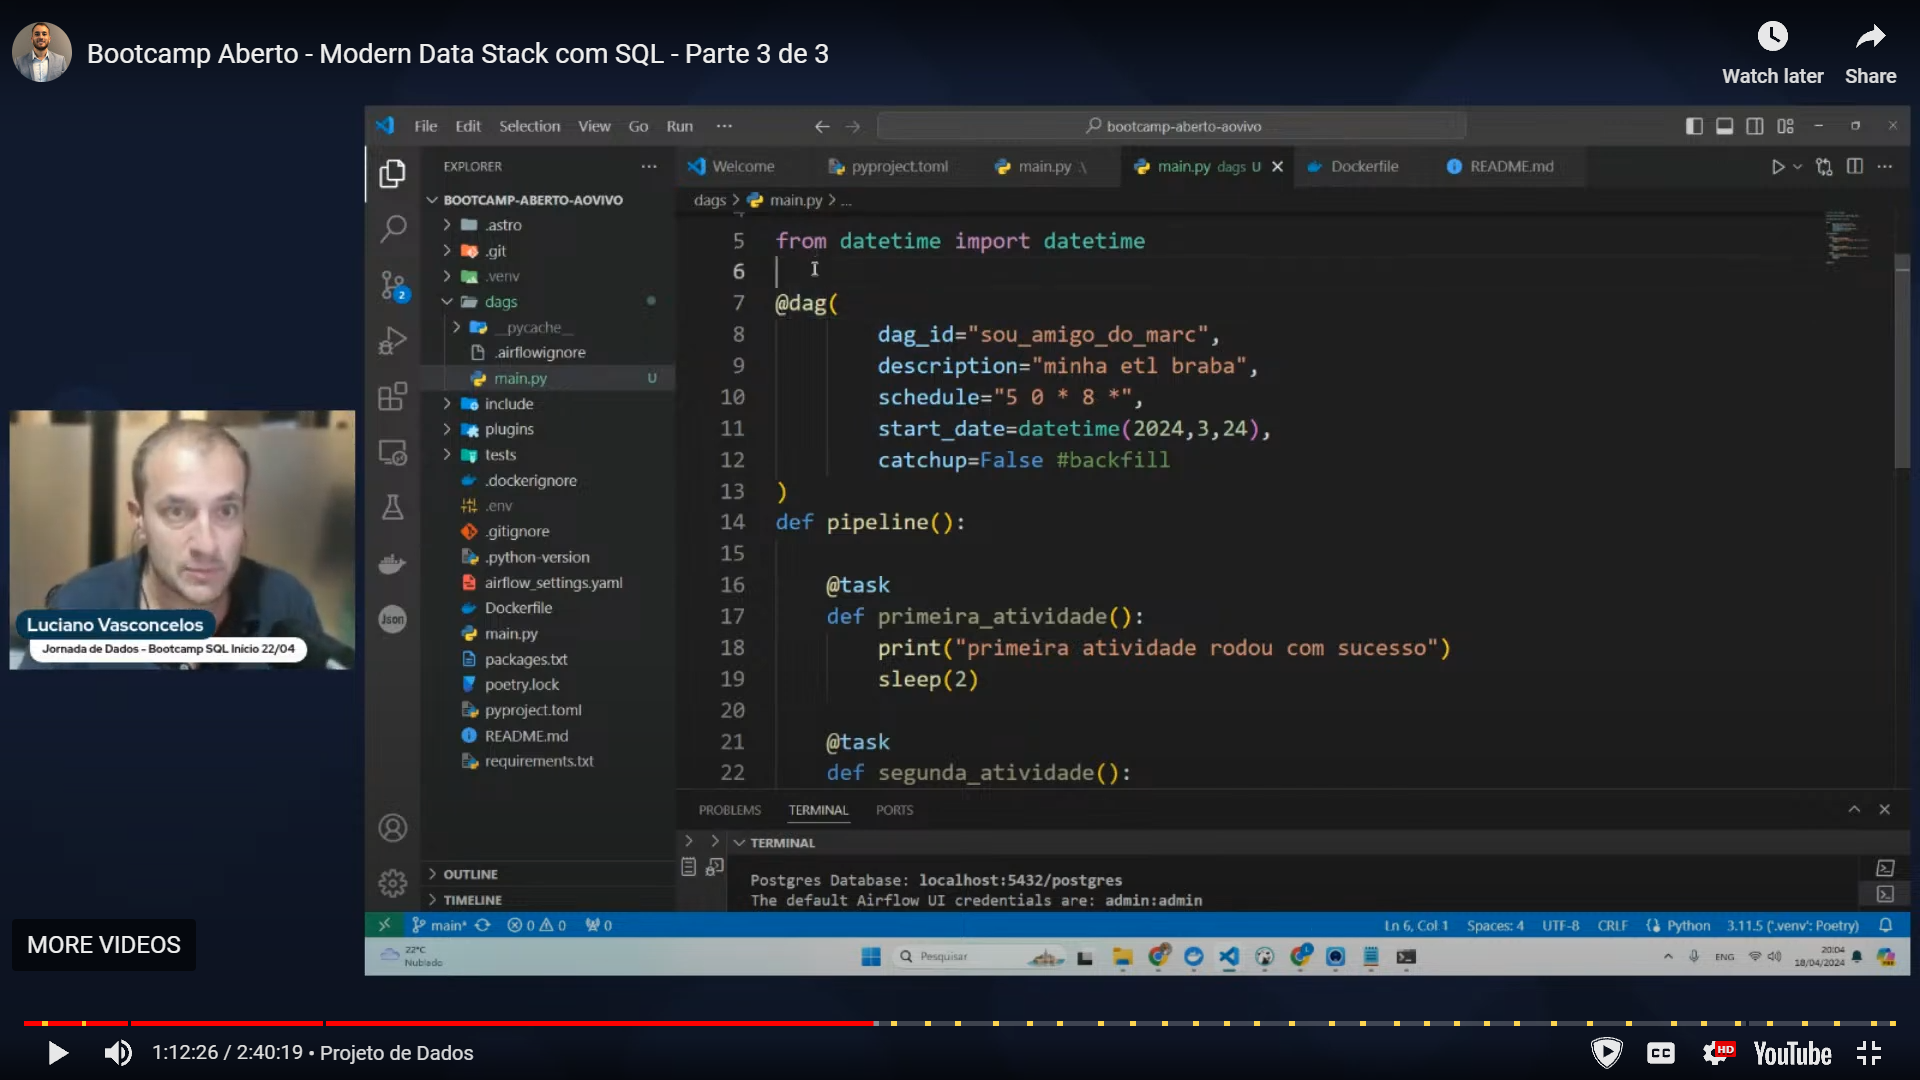